# Seeded Graph Matching (SGM)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

Seeded Graph Matching (SGM) is a version of the graph matching problem where one is first given a partial alignment of the nodes. This algorithm is an modification of the Fast Approximate QAP (FAQ) algorithm (Vogelstein, 2015), as described in Seeded graph matching (Fishkind, 2018). For a more in depth explanation of the graph matching problem and FAQ, view the FAQ tutorial.

In [21]:
from graspy.match import SeededGraphMatching as SGM
from graspy.plot import heatmap
from graspy.simulations import er_corr, sbm, sbm_corr

## SGM on Correlated Graph Pairs
To demonstrate the effectiveness of SGM, the algorithm will be applied on a pair of correlated SBM graphs (undirected, no self loops) $G_1, G_2 \sim SBM\,(n, p, rho)$  with the following parameters:
\begin{align*}
n &= [100, 100, 100]\\
p &= \begin{bmatrix} 
0.7 & 0.3 & 0.4\\
0.3 & 0.7 & 0.3\\
0.4 & 0.3 & 0.7
\end{bmatrix}\\
rho &= 0.9
\end{align*}

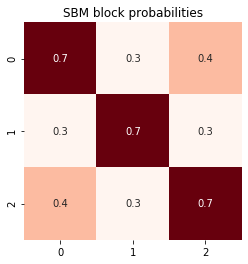

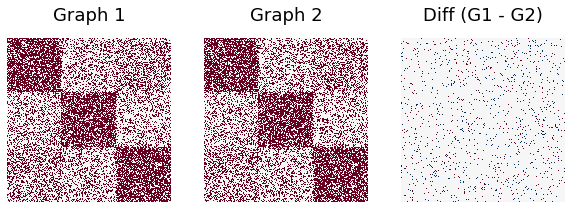

In [10]:
directed = False
loops = False
n_per_block = 100
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
n_verts = block_members.sum()
rho = .9
block_probs = np.array([[0.7, 0.3, 0.4], [0.3, 0.7, 0.3], [0.4, 0.3, 0.7]])
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(block_probs, cbar=False, annot=True, square=True, cmap="Reds", ax=ax)
ax.set_title("SBM block probabilities")

A1, A2 = sbm_corr(block_members, block_probs, rho, directed=directed, loops=loops)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2, ax=axs[1], cbar=False, title="Graph 2")
heatmap(A1 - A2, ax=axs[2], cbar=False, title="Diff (G1 - G2)")

To demonstrate the effectiveness of SGM, as well as why having seeds is important, we will randomly shuffle the vertices of Graph 2. First, we will run SGM on graph 1 and the shuffled graph 2 with no seeds, and return the match ratio, that is the fraction of vertices that have been correctly matched. Then, we will run SGM with 10 seeds, and demonstrate how much more accurate the matching can be with a seeding as low as ~ 3%.


## Heat maps with shuffled graph 2

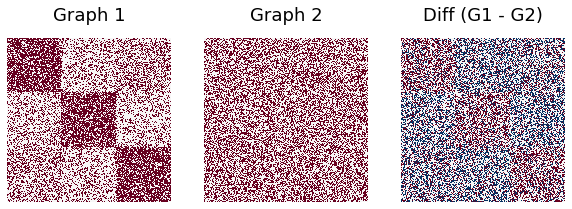

In [12]:
n=300
node_shuffle_input = np.random.permutation(n)
A2_shuffle = A2[np.ix_(node_shuffle_input, node_shuffle_input)]
node_unshuffle_input = np.array(range(n))
node_unshuffle_input[node_shuffle_input] = np.array(range(n))

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_shuffle, ax=axs[1], cbar=False, title="Graph 2")
heatmap(A1 - A2_shuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2)")


## Heat maps with graph 2 unshuffled with SGM (no seeds)

Match Ratio with no seeds:  0.01666666666666672


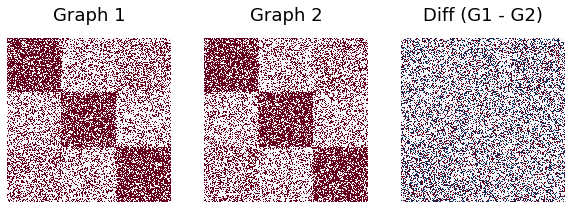

In [20]:
sgm = SGM(gmp=True)
sgm = sgm.fit(A1,A2_shuffle)
A2_unshuffle = A2_shuffle[np.ix_(sgm.perm_inds_, sgm.perm_inds_)]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_unshuffle, ax=axs[1], cbar=False, title="Graph 2")
heatmap(A1 - A2_unshuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2)")

match_ratio = 1-(np.count_nonzero(abs(sgm.perm_inds_-node_unshuffle_input))/n)
print("Match Ratio with no seeds: ", match_ratio)

## Heat maps with graph 2 unshuffled with SGM (10 seeds)

Match Ratio with 10 seeds:  1.0


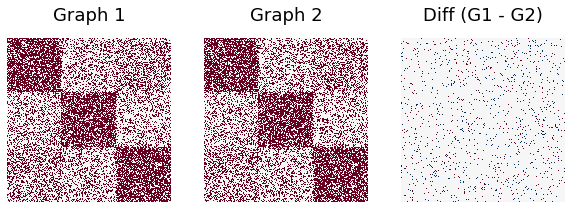

In [19]:
W1 = np.sort(random.sample(list(range(n)),10))
W1 = W1.astype(int)
W2 = np.array(node_unshuffle_input[W1])
    
sgm = SGM(gmp=True)
sgm = sgm.fit(A1,A2_shuffle,W1,W2)
A2_unshuffle = A2_shuffle[np.ix_(sgm.perm_inds_, sgm.perm_inds_)]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_unshuffle, ax=axs[1], cbar=False, title="Graph 2")
heatmap(A1 - A2_unshuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2)")

match_ratio = 1-(np.count_nonzero(abs(sgm.perm_inds_-node_unshuffle_input))/n)
print("Match Ratio with 10 seeds: ", match_ratio)


From the results above, we see that when running SGM on the same two graphs, with no seeds there is match ratio of only about 1.7%, however including 10 seeds increases the match ratio to 100% (meaning that the shuffled graph 2 was completely correctly unshuffled)